### Optimizing ANN using following:
- Dropouts
- Regualarization (L2)
- Batch Normalization

#### Dropouts
###### Randomly turn off some neurons in the neural network in each forward pass, and dropouts doesn't work during dropouts
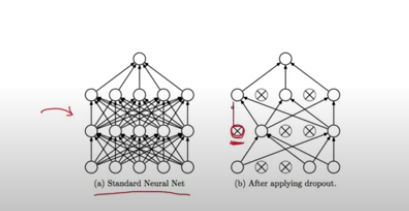

#### Batch Normalization
This prevents Internal Covariate Shif, as the weights constantly changes during training becomes unstable to prevent that batch normalization is used
During training, for each mini-batch, BatchNorm:

Normalizes the input values to a layer (like z-values) so they have:

Mean = 0

Variance = 1

Then, it scales and shifts these normalized values using two learned parameters:

γ (gamma) – scale

β (beta) – shift

The idea is to keep the distribution of inputs to a layer more stable across training, which makes the network train faster and more reliably.
This is applied after Linear Layer before activation function

#### Regularization
- You add a penalty term to the Loss that prevents High values of weights
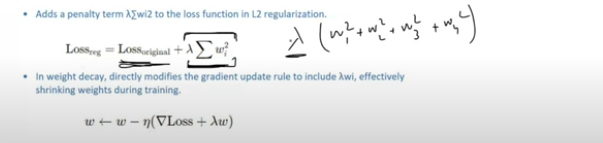

In [61]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
torch.manual_seed(42)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## its a better approach to do train test split first then apply data transformation
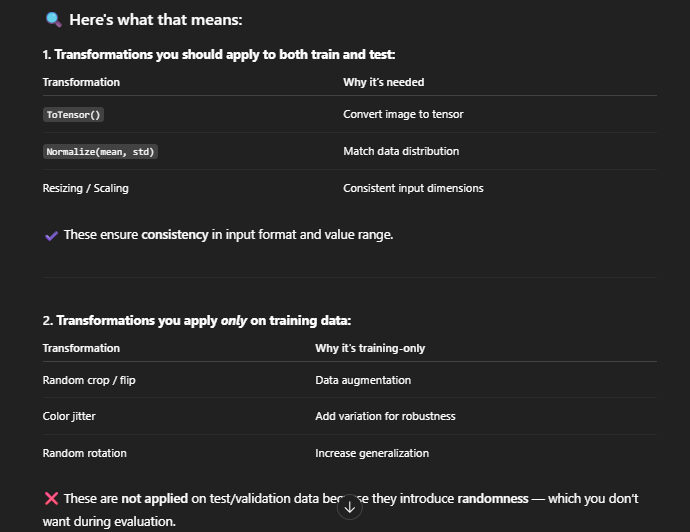

In [ ]:
df = pd.read_csv('fmnist_small.csv')
df.head()

In [ ]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# # Plot the first 16 images from the dataset
# for i, ax in enumerate(axes.flat):
#     img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
#     ax.imshow(img)  # Display in grayscale
#     ax.axis('off')  # Remove axis for a cleaner look
#     ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
# plt.show()


In [ ]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scaling the feautures
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
X_train

In [ ]:
class MyDataset(Dataset):
  def __init__(self,features,labels):
    self.features = torch.tensor(features,dtype=torch.float32)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index], self.labels[index]

In [ ]:
training_data = MyDataset(X_train,y_train)
test_data = MyDataset(X_test,y_test)

In [ ]:
train_loader = DataLoader(training_data, shuffle = True,batch_size = 128,pin_memory=True)
test_loader = DataLoader(test_data,shuffle=False,batch_size= 128,pin_memory = True) # you cant create randomness in the testing data

In [57]:
## Creating a Neural Network
class MyNN(nn.Module):
  def __init__(self,num_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features,128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(128,64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(64,10)
    )

  def forward(self,X):  # implement --> model() <-- method
    return self.model(X)

In [58]:
learning_rate = 0.08
epochs = 100

In [60]:
model = MyNN(X_train.shape[1])
model = model.to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay = 1e-4)

In [ ]:
for i in range(epochs):
  epoch_loss = 0
  for batch_X,batch_y in train_loader:
    batch_X,batch_y = batch_X.to(device) ,batch_y.to(device)

    outputs = model(batch_X)

    loss = criterion(outputs , batch_y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    epoch_loss += loss.item()

  avg_loss = epoch_loss/len(train_loader)
  print(f"avg Training loss at epoch {i+1}: ",avg_loss)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
summary(model, input_size=(1, 784))

In [ ]:
model.eval() ## tells the model that it i will be used for evaluation ,usefull when training and testing requires different behaviours

In [ ]:
total = 0
correct = 0

# We don't need gradients during evaluation
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X,batch_y = batch_X.to(device) ,batch_y.to(device)
        output = model(batch_X)

        # Get predicted class (index of max value along dim=1)
        _, y_pred = torch.max(output, 1)

        total += batch_y.size(0)  # or len(batch_y)
        correct += (y_pred == batch_y).sum().item()

accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy:.2f}%")

